# Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from tqdm import tqdm
import numpy as np
import tensorflow as tf

In [4]:
import sys
sys.path.insert(0, '../.')

In [5]:
from model import *
from Trainer import *

In [6]:
from data.preprocessing import *

In [7]:
from data.target_utils import *

# Test the evaluation

In [8]:
#https://github.com/charlesq34/frustum-pointnets/blob/2ffdd345e1fce4775ecb508d207e0ad465bcca80/kitti/kitti_util.py#L253

In [539]:
g = data_generator(base_path = '/Users/apple/Desktop/Master/Data')
# with tf.Session() as sess:
camera_tensor, lidar_tensor, fv_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = next(g)

In [526]:
base_path = '/Users/apple/Desktop/Master/Data/'
# file_name = camera_path.split('/')[-1].split('.')[0]
file_name = '000008'

In [527]:
def __read_label(label_path, calib_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), size=(512, 448, 32)):
    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    lines = []
    with open(label_path) as label_file:
        lines = label_file.readlines()
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    lines = list(filter(lambda x: x[0] in ['Car', 'Van', 'Truck'], lines))
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = get_parameter(0)
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    

    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    print(locations[-1])
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    
    print(locations[-1])


    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(classes))]    
    
    x_range=(0, 70)
    y_range=(-40, 40)
    z_range=(-2.5, 1)
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    
    print(points[-1])
    for p in points[-1]:
        print( -(p + np.array([0, 40, 2.5]))* np.array([x_fac, y_fac, z_fac]) + size )
    
    
    import math
    for i in range(len(points)):
        b = points[i]
        x0 = b[0][0]
        y0 = b[0][1]
        x1 = b[1][0]
        y1 = b[1][1]
        x2 = b[2][0]
        y2 = b[2][1]
        u0 = -(x0) * x_fac + size[0]
        v0 = -(y0 + 40) * y_fac + size[1]
        u1 = -(x1) * x_fac + size[0]
        v1 = -(y1 + 40) * y_fac + size[1]
        u2 = -(x2) * x_fac + size[0]
        v2 = -(y2 + 40) * y_fac + size[1]
        # print(dimension_length[i])
        dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
        # print(dimension_length[i])
        dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
        # print(dimension_height[i])
        dimension_height[i] = math.sqrt((-(b[0][2]+2.5)*z_fac+(-b[4][2]-2.5)*z_fac)**2)
        # print(dimension_height[i])

      


    # k = 3
    # output = [[-(points[i][k][0]) * x_fac + size[0], -(points[i][k][1] + 40) * y_fac + size[1], -(points[i][k][2] + 2.5) * z_fac + size[2], 
    #             dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
    #             for i in range(len(classes))]

    output = [[-(locations[i][0]) * x_fac + size[0], -(locations[i][1] + 40) * y_fac + size[1], -(locations[i][2] + 2.5) * z_fac + size[2], 
                dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
                for i in range(len(classes))]
    print([-(locations[-1][0]) * x_fac + size[0], -(locations[-1][1] + 40) * y_fac + size[1], -(locations[-1][2] + 2.5) * z_fac + size[2]])
    # for i in range(len(output)):
    #     w = output[i][5] 
    #     h = output[i][4] 
    #     x = output[i][0]
    #     y = output[i][1]

    #     rect = patches.Rectangle((y, x),w, h, angle= output[i][6]*57.2958)

    #     if output[i][6] >0:
    #         origin = np.array(rect.get_bbox().get_points()[0])
    #         point =  np.array(rect.get_bbox().get_points()[1])
    #         p = rotate(origin, point, output[i][6])
    #         output[i][0] = p[1]
    #         output[i][1] = p[0]
    #         output[i][6] = output[i][6] - 3.14

    
    output = np.array(list(filter(lambda point: point[0] >= x_range[0]  or point[0] <= x_range[1]
                                    and point[1] >= y_range[0] or point[1] <= y_range[1]
                                    and point[2] >= z_range[0] or point[2] <= z_range[1] , output)))

    
    
    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']


In [528]:
all_data, label, Tr_velo_to_cam, R0_rect, P3 = read_label(base_path + 'training/label_2/'+ file_name + '.txt', 
                                                  base_path + 'data_object_calib/training/calib/'+ file_name + '.txt', 
                                                  shift_h, shift_w, size=(128*4, 112*4, 1*32))

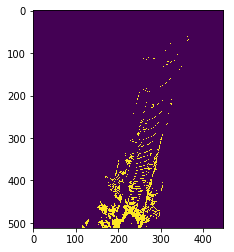

In [245]:
lidar_image = velo_points_bev(base_path + 'data_object_velodyne/training/velodyne/'+ file_name + '.bin', 
                           size=(512, 448, 32))
# lidar_image = velo_points_bev('/Users/apple/Downloads/000001.bin', size=(512, 448, 32))
plt.imshow(np.clip(np.mean(lidar_image, 2), 0, 1))

209.32031978493978 483.0171691370539
217.87112562517254 452.5090766565182
245.69709984562192 464.98362361239475
230.3877574480517 404.48148581250047
264.84767040762824 267.53038146214425
271.7731769916455 364.1597281063003


<Figure size 432x288 with 0 Axes>

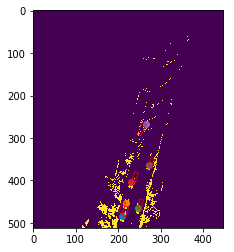

In [401]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 9:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][5] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    plt.scatter(y, x)
#     print(label[i][6]*57.2958, y, x, w, h)
    print(y, x)
    rect = patches.Rectangle((y, x),w, h, angle= label[i][6]*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
#     break

plt.show()


202.60653246984342 492.75842138947894
208.4463755348762 463.6243054395442
239.59264873358845 474.49156930364245
222.92303419071038 415.319187763255
253.7281426823189 279.2379321338143
265.3828235786586 370.88691916033696


<Figure size 432x288 with 0 Axes>

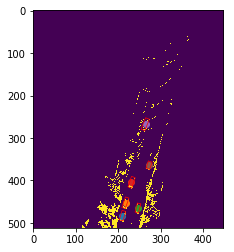

In [247]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 9:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][5] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    
    x1 = output[i][0]
    y1 = output[i][1]
    plt.scatter(y1, x1)
#     print(label[i][6]*57.2958, y, x, w, h)
    print(y, x)
    rect = patches.Rectangle((y, x),w, h, angle= label[i][6]*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
#     break

plt.show()


In [65]:
label

array([[492.75842139, 202.60653247, -24.84774655,  27.92712505,
          9.0062148 ,  23.20077437,  -1.29      ],
       [463.62430544, 208.44637553,  10.90177976,  28.96942527,
          8.6841844 ,  26.2760902 ,  -1.24      ],
       [474.4915693 , 239.59264873,  33.78157166,  27.05842921,
          8.23191052,  22.171998  ,  -1.31      ],
       [415.31918776, 222.92303419,   7.35738242,  31.44513578,
          9.24761811,  26.16201625,  -1.25      ],
       [279.23793213, 253.72814268,  87.20699661,  34.99130205,
          9.53720423,  28.92663156,  -1.19      ],
       [370.88691916, 265.38282358,  74.66340842,  28.53016631,
          9.1898205 ,  17.65578692,  -1.25      ]])

In [67]:
label_tensor.shape

(128, 112, 2, 9)

In [420]:
np.where(label_tensor[:, :, :, 7]>0)

(array([ 69,  92, 103, 115, 118, 123]),
 array([63, 66, 55, 52, 59, 50]),
 array([1, 1, 1, 1, 1, 1]))

In [421]:
len(np.where(test1[:, :, :, 7]>0)[0])

6

In [70]:
label_tensor[69, 63, 1, :]

array([ 0.10061682,  0.16444236,  0.294916  ,  1.4700232 ,  1.2892523 ,
        1.1411494 , -2.7607963 ,  1.        ,  1.        ], dtype=float32)

In [81]:
def cart2hom(pts_3d):
        ''' Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        '''
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
        return pts_3d_hom

def inverse_rigid_trans(Tr):
    ''' Inverse a rigid body transform matrix (3x4 as [R|t])
        [R'|-R't; 0|1]
    '''
    inv_Tr = np.zeros_like(Tr) # 3x4
    inv_Tr[0:3,0:3] = np.transpose(Tr[0:3,0:3])
    inv_Tr[0:3,3] = np.dot(-np.transpose(Tr[0:3,0:3]), Tr[0:3,3])
    return inv_Tr

def project_rect_to_ref(pts_3d_rect, RO):
        ''' Input and Output are nx3 points '''
        return np.transpose(np.dot(np.linalg.inv(RO), np.transpose(pts_3d_rect)))
    
def project_ref_to_velo(pts_3d_ref, Tr_velo_to_cam):
        C2V = inverse_rigid_trans(Tr_velo_to_cam)
        pts_3d_ref = cart2hom(pts_3d_ref) # nx4
        return np.dot(pts_3d_ref, np.transpose(C2V))
    
def project_rect_to_velo(pts_3d_rect, RO, Tr_velo_to_cam):
        ''' Input: nx3 points in rect camera coord.
            Output: nx3 points in velodyne coord.
        ''' 
        pts_3d_ref = project_rect_to_ref(pts_3d_rect, RO)
        return project_ref_to_velo(pts_3d_ref, Tr_velo_to_cam)
    
    

x_range=(0, 70)
y_range=(-40, 40)
z_range=(-2.5, 1)
size=(512, 448, 32)

lines = []
with open('/Users/apple/Desktop/Master/Data/training/label_2/000008.txt') as label_file:
        lines = label_file.readlines()
    # filter car class
lines = list(map(lambda x: x.split(), lines))
lines = list(filter(lambda x: x[0] in ['Car', 'Van', 'Truck'], lines))
def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
classes = get_parameter(0)
dimension_height = np.array(get_parameter(8)).astype(float)
dimension_width = np.array(get_parameter(9)).astype(float)
dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
location_x = np.array(get_parameter(11)).astype(float)
location_y = np.array(get_parameter(12)).astype(float)
location_z = np.array(get_parameter(13)).astype(float)
angles = np.array(get_parameter(14)).astype(float)
    

calib_data = read_calib(base_path + 'data_object_calib/training/calib/'+ file_name + '.txt')

print('from file')
for i in range(len(classes)):
    print([location_x[i], location_y[i], location_z[i]])
    

print()

locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
print(locations.shape)
locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))

print('Locations')
print(locations)

print()


points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(classes))]

print(points[4])
# print('after projection')
# for i in range(len(classes)):
#     print(points[i][3][:3])
    
print()
    
x_range=(0, 70)
y_range=(-40, 40)
z_range=(-2.5, 1)
    
x_size = (x_range[1] - x_range[0])
y_size = (y_range[1] - y_range[0])
z_size = (z_range[1] - z_range[0])
            
x_fac = (size[0]-1) / x_size
y_fac = (size[1]-1) / y_size
z_fac = (size[2]-1) / z_size
import math
for i in range(len(points)):
        b = points[i]
        x0 = b[0][0]
        y0 = b[0][1]
        x1 = b[1][0]
        y1 = b[1][1]
        x2 = b[2][0]
        y2 = b[2][1]
        u0 = -(x0) * x_fac + size[0]
        v0 = -(y0 + 40) * y_fac + size[1]
        u1 = -(x1) * x_fac + size[0]
        v1 = -(y1 + 40) * y_fac + size[1]
        u2 = -(x2) * x_fac + size[0]
        v2 = -(y2 + 40) * y_fac + size[1]
        # print(dimension_length[i])
        dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
        # print(dimension_length[i])
        dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
        # print(dimension_height[i])
        dimension_height[i] = math.sqrt((-(b[0][2]+2.5)*z_fac+(-b[4][2]-2.5)*z_fac)**2)
        # print(dimension_height[i])

# print(len(classes), len(points))
    
print()

k = 3
output = [[-(points[i][k][0]) * x_fac + size[0], -(points[i][k][1] + 40) * y_fac + size[1], -(points[i][k][2] + 2.5) * z_fac + size[2], 
                dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
                for i in range(len(classes))]

k = 3
output = [[-(locations[i][0]) * x_fac + size[0], -(locations[i][1] + 40) * y_fac + size[1], -(locations[i][2] + 2.5) * z_fac + size[2], 
                dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
                for i in range(len(classes))]

# for i in range(len(output)):
#         w = output[i][5] 
#         h = output[i][4] 
#         x = output[i][0]
#         y = output[i][1]

#         rect = patches.Rectangle((y, x),w, h, angle= output[i][6]*57.2958)

#         if output[i][6] >0:
#             print('enter', i)
#             origin = np.array(rect.get_bbox().get_points()[0])
#             point =  np.array(rect.get_bbox().get_points()[1])
#             p = rotate(origin, point, output[i][6])
#             output[i][0] = p[1]
#             output[i][1] = p[0]
#             output[i][6] = output[i][6] - 3.14

    
output = np.array(list(filter(lambda point: point[0] >= x_range[0]  or point[0] <= x_range[1]
                                    and point[1] >= y_range[0] or point[1] <= y_range[1]
                                    and point[2] >= z_range[0] or point[2] <= z_range[1] , output)))

print()
print('final')
print(output[:, :3])

from file
[-2.7, 1.74, 3.68]
[-1.17, 1.65, 7.86]
[3.81, 1.64, 6.15]
[1.07, 1.55, 14.44]
[7.24, 1.55, 33.2]
[8.48, 1.75, 19.96]

(6, 3)
Locations
[[ 3.9702508   2.71672129 -1.74511171]
 [ 8.14944155  1.18637573 -1.62759732]
 [ 6.44059951 -3.7936644  -1.68807627]
 [14.72856359 -1.05373735 -1.48250097]
 [33.48898884 -7.22105958 -1.35161118]
 [20.25209204 -8.46052385 -1.70306308]]

[[31.29233393 -7.22326595 -1.37459077]
 [31.89534027 -5.70907116 -1.35228924]
 [35.68564376 -7.21885321 -1.3286316 ]
 [35.08263741 -8.733048   -1.35093312]
 [31.27456993 -7.24122705  0.32522164]
 [31.87757628 -5.72703226  0.34752317]
 [35.66787976 -7.23681432  0.37118081]
 [35.06487341 -8.75100911  0.34887929]]



final
[[483.01716914 209.32031978  25.31384662]
 [452.50907666 217.87112563  24.27300483]
 [464.98362361 245.69709985  24.80867555]
 [404.48148581 230.38775745  22.98786574]
 [267.53038146 264.84767041  21.82855617]
 [364.15972811 271.77317699  24.94141583]]


In [529]:
def convert_prediction_into_real_values(label_tensor_input,
            anchors=np.array([1.6, 3.9, 1.5]), 
            input_size=(512, 448), output_size=(128, 112)):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(label_tensor_input[:, :, :, 7]>0)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], ones_index[2][i], :])
            anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])
            
            out[:3] = out[:3] * anchor[3:6] + anchor[:3]
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 32.
            
            out[3:6] = np.exp(out[3:6]) * anchor[3:6]
            
            k = ones_index[2][i]

            out[6] = out[6] + k * (np.pi/2)
                        
            result.append(out)
            
    return np.array(result)

In [530]:
output

array([[483.01716914, 209.32031978,  25.31384662,  27.92712505,
          9.0062148 ,  23.20077437,  -1.29      ],
       [452.50907666, 217.87112563,  24.27300483,  28.96942527,
          8.6841844 ,  26.2760902 ,   1.9       ],
       [464.98362361, 245.69709985,  24.80867555,  27.05842921,
          8.23191052,  22.171998  ,  -1.31      ],
       [404.48148581, 230.38775745,  22.98786574,  31.44513578,
          9.24761811,  26.16201625,  -1.25      ],
       [267.53038146, 264.84767041,  21.82855617,  34.99130205,
          9.53720423,  28.92663156,   1.95      ],
       [364.15972811, 271.77317699,  24.94141583,  28.53016631,
          9.1898205 ,  17.65578692,  -1.25      ]])

In [531]:
output2 = convert_prediction_into_real_values(label_tensor)

In [532]:
output2.shape

(6, 9)

In [533]:
label

array([[483.01716914, 209.32031978,  25.31384662,   1.6       ,
          1.57      ,   3.23      ,  -1.29      ],
       [452.50907666, 217.87112563,  24.27300483,   1.57      ,
          1.5       ,   3.68      ,   1.9       ],
       [464.98362361, 245.69709985,  24.80867555,   1.39      ,
          1.44      ,   3.08      ,  -1.31      ],
       [404.48148581, 230.38775745,  22.98786574,   1.47      ,
          1.6       ,   3.66      ,  -1.25      ],
       [267.53038146, 264.84767041,  21.82855617,   1.7       ,
          1.63      ,   4.08      ,   1.95      ],
       [364.15972811, 271.77317699,  24.94141583,   1.59      ,
          1.59      ,   2.47      ,  -1.25      ]])

In [534]:
output2

array([[267.5304   , 264.84766  ,  21.828556 ,   1.7      ,   1.63     ,
          4.08     ,   1.95     ,   1.       ,   1.       ],
       [364.15973  , 271.77316  ,  24.941416 ,   1.5899999,   1.5899999,
          2.47     ,  -1.2499999,   1.       ,   1.       ],
       [404.48148  , 230.38776  ,  22.987865 ,   1.47     ,   1.6      ,
          3.66     ,  -1.2499999,   1.       ,   1.       ],
       [452.50906  , 217.87112  ,  24.273005 ,   1.5699999,   1.5      ,
          3.68     ,   1.9      ,   1.       ,   1.       ],
       [464.9836   , 245.6971   ,  24.808676 ,   1.3899999,   1.44     ,
          3.08     ,  -1.3100001,   1.       ,   1.       ],
       [483.01718  , 209.32031  ,  25.313847 ,   1.6      ,   1.5699999,
          3.23     ,  -1.2899998,   1.       ,   1.       ]],
      dtype=float32)

In [535]:
output

array([[483.01716914, 209.32031978,  25.31384662,  27.92712505,
          9.0062148 ,  23.20077437,  -1.29      ],
       [452.50907666, 217.87112563,  24.27300483,  28.96942527,
          8.6841844 ,  26.2760902 ,   1.9       ],
       [464.98362361, 245.69709985,  24.80867555,  27.05842921,
          8.23191052,  22.171998  ,  -1.31      ],
       [404.48148581, 230.38775745,  22.98786574,  31.44513578,
          9.24761811,  26.16201625,  -1.25      ],
       [267.53038146, 264.84767041,  21.82855617,  34.99130205,
          9.53720423,  28.92663156,   1.95      ],
       [364.15972811, 271.77317699,  24.94141583,  28.53016631,
          9.1898205 ,  17.65578692,  -1.25      ]])

1 type Describes the type of object: 'Car', 'Van', 'Truck',

'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',

'Misc' or 'DontCare'

1 truncated Float from 0 (non-truncated) to 1 (truncated), where

truncated refers to the object leaving image boundaries

1 occluded Integer (0,1,2,3) indicating occlusion state:

0 = fully visible, 1 = partly occluded

2 = largely occluded, 3 = unknown

1 alpha Observation angle of object, ranging [-pi..pi]

4 bbox 2D bounding box of object in the image (0-based index):

contains left, top, right, bottom pixel coordinates

3 dimensions 3D object dimensions: height, width, length (in meters)

3 location 3D object location x,y,z in camera coordinates (in meters)

1 rotation_y Rotation ry around Y-axis in camera coordinates [-pi..pi]

1 score Only for results: Float, indicating confidence in

detection, needed for p/r curves, higher is better.

In [551]:
def project_velo_to_ref(pts_3d_velo, Tr_velo_to_cam):
        pts_3d_velo = cart2hom(pts_3d_velo) # nx4
        return np.dot(pts_3d_velo, np.transpose(Tr_velo_to_cam))

    
def project_ref_to_rect(pts_3d_ref, R0_rect):
        ''' Input and Output are nx3 points '''
        return np.transpose(np.dot(R0_rect, np.transpose(pts_3d_ref)))




def get_points(converted_points, calib_path, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), size=(512, 448, 32)):
    all_result = []
    for converted_points_ in converted_points:
        if converted_points_[8] >= 0.5:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8:11] = converted_points_[3:6]
            result[14] = converted_points_[6]
            result[15] = converted_points_[8]

            calib_data = read_calib(calib_path)

            x_range=(0, 70)
            y_range=(-40, 40)
            z_range=(-2.5, 1)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size

            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, 40, 2.5]) 
            point = np.array([[x, y, z]])
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]
                
            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[3], converted_points_[4],
                         converted_points_[5], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox

            all_result.append(result)
    return all_result

In [554]:
r = get_points(output2, base_path + 'data_object_calib/training/calib/'+ file_name + '.txt')
print(r)

[['Car', -1, -1, -10, 741.6705720546863, 169, 792, 208, 1.7, 1.63, 4.08, 7.239997014702882, 1.550000170811046, 33.20000109125683, 1.95, 1.0], ['Car', -1, -1, -10, 885.3754565486468, 178, 956, 240, 1.5899999, 1.5899999, 2.47, 8.479996942847944, 1.7500001788807147, 19.960001700877136, -1.2499999, 1.0], ['Car', -1, -1, -10, 598.0678692066649, 176, 721, 262, 1.47, 1.6, 3.66, 1.0699997359923956, 1.5500001100179241, 14.440002695355227, -1.2499999, 1.0], ['Car', -1, -1, -10, 335.78314860890737, 178, 624, 375, 1.5699999, 1.5, 3.68, -1.1700001704804381, 1.6500001008116933, 7.860002508413314, 1.9, 1.0], ['Car', -1, -1, -10, 938.8091555872564, 195, 1281, 436, 1.3899999, 1.44, 3.08, 3.809999396307669, 1.6400001601411447, 6.150002163389705, -1.3100001, 1.0], ['Car', -1, -1, -10, -570.800489920303, 191, 402, 828, 1.6, 1.5699999, 3.23, -2.7000011364945395, 1.7400001002822507, 3.6799986813241996, -1.2899998, 1.0]]


In [564]:
res = '\n'.join([' '.join([str(l) for l in r[i]]) for i in range(len(r))])
print(res)

Car -1 -1 -10 741.6705720546863 169 792 208 1.7 1.63 4.08 7.239997014702882 1.550000170811046 33.20000109125683 1.95 1.0
Car -1 -1 -10 885.3754565486468 178 956 240 1.5899999 1.5899999 2.47 8.479996942847944 1.7500001788807147 19.960001700877136 -1.2499999 1.0
Car -1 -1 -10 598.0678692066649 176 721 262 1.47 1.6 3.66 1.0699997359923956 1.5500001100179241 14.440002695355227 -1.2499999 1.0
Car -1 -1 -10 335.78314860890737 178 624 375 1.5699999 1.5 3.68 -1.1700001704804381 1.6500001008116933 7.860002508413314 1.9 1.0
Car -1 -1 -10 938.8091555872564 195 1281 436 1.3899999 1.44 3.08 3.809999396307669 1.6400001601411447 6.150002163389705 -1.3100001 1.0
Car -1 -1 -10 -570.800489920303 191 402 828 1.6 1.5699999 3.23 -2.7000011364945395 1.7400001002822507 3.6799986813241996 -1.2899998 1.0


In [547]:
# https://github.com/fregu856/3DOD_thesis/blob/master/evaluation/create_txt_files_val.py
def ProjectTo2Dbbox(center, h, w, l, r_y, P2):
    # input: 3Dbbox in (rectified) camera coords

    Rmat = np.asarray([[math.cos(r_y), 0, math.sin(r_y)],
                       [0, 1, 0],
                       [-math.sin(r_y), 0, math.cos(r_y)]],
                       dtype='float32')

    p0 = center + np.dot(Rmat, np.asarray([l/2.0, 0, w/2.0], dtype='float32').flatten())
    p1 = center + np.dot(Rmat, np.asarray([-l/2.0, 0, w/2.0], dtype='float32').flatten())
    p2 = center + np.dot(Rmat, np.asarray([-l/2.0, 0, -w/2.0], dtype='float32').flatten())
    p3 = center + np.dot(Rmat, np.asarray([l/2.0, 0, -w/2.0], dtype='float32').flatten())
    p4 = center + np.dot(Rmat, np.asarray([l/2.0, -h, w/2.0], dtype='float32').flatten())
    p5 = center + np.dot(Rmat, np.asarray([-l/2.0, -h, w/2.0], dtype='float32').flatten())
    p6 = center + np.dot(Rmat, np.asarray([-l/2.0, -h, -w/2.0], dtype='float32').flatten())
    p7 = center + np.dot(Rmat, np.asarray([l/2.0, -h, -w/2.0], dtype='float32').flatten())

    points = np.array([p0, p1, p2, p3, p4, p5, p6, p7])

    points_hom = np.ones((points.shape[0], 4)) # (shape: (8, 4))
    points_hom[:, 0:3] = points

    # project the points onto the image plane (homogeneous coords):
    img_points_hom = np.dot(P2, points_hom.T).T # (shape: (8, 3)) (points_hom.T has shape (4, 8))
    # normalize:
    img_points = np.zeros((img_points_hom.shape[0], 2)) # (shape: (8, 2))
    img_points[:, 0] = img_points_hom[:, 0]/img_points_hom[:, 2]
    img_points[:, 1] = img_points_hom[:, 1]/img_points_hom[:, 2]

    u_min = np.min(img_points[:, 0])
    v_min = np.min(img_points[:, 1])
    u_max = np.max(img_points[:, 0])
    v_max = np.max(img_points[:, 1])

    left = int(u_min)
    top = int(v_min)
    right = int(u_max)
    bottom = int(v_max)

    projected_2Dbbox = [left, top, right, bottom]

    return projected_2Dbbox

In [548]:
calib_data = read_calib(base_path + 'data_object_calib/training/calib/'+ file_name + '.txt')

In [549]:
calib_data.keys()

dict_keys(['P0', 'P1', 'P2', 'P3', 'R0_rect', 'Tr_velo_to_cam', 'Tr_imu_to_velo'])

In [545]:
calib_data['P2'].shape

(12,)

In [550]:
ProjectTo2Dbbox([8.48, 1.75, 19.96], 1.59, 1.59, 2.47, -1.25, calib_data['P2'].reshape((3, 4)))

[885.3755741207048, 178, 956, 240]

In [448]:
!cat /Users/apple/Desktop/Master/Data/training/label_2/000008.txt

Car 0.88 3 -0.69 0.00 192.37 402.31 374.00 1.60 1.57 3.23 -2.70 1.74 3.68 -1.29
Car 0.00 1 2.04 334.85 178.94 624.50 372.04 1.57 1.50 3.68 -1.17 1.65 7.86 1.90
Car 0.34 3 -1.84 937.29 197.39 1241.00 374.00 1.39 1.44 3.08 3.81 1.64 6.15 -1.31
Car 0.00 1 -1.33 597.59 176.18 720.90 261.14 1.47 1.60 3.66 1.07 1.55 14.44 -1.25
Car 0.00 0 1.74 741.18 168.83 792.25 208.43 1.70 1.63 4.08 7.24 1.55 33.20 1.95
Car 0.00 0 -1.65 884.52 178.31 956.41 240.18 1.59 1.59 2.47 8.48 1.75 19.96 -1.25
DontCare -1 -1 -10 800.38 163.67 825.45 184.07 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 859.58 172.34 886.26 194.51 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 801.81 163.96 825.20 183.59 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 826.87 162.28 845.84 178.86 -1 -1 -1 -1000 -1000 -1000 -10


In [249]:
label

array([[492.75842139, 202.60653247,  25.32490894,  27.92712505,
          9.0062148 ,  23.20077437,  -1.29      ],
       [463.62430544, 208.44637553,  24.25632905,  28.96942527,
          8.6841844 ,  26.2760902 ,  -1.24      ],
       [474.4915693 , 239.59264873,  24.82698583,  27.05842921,
          8.23191052,  22.171998  ,  -1.31      ],
       [415.31918776, 222.92303419,  23.00025277,  31.44513578,
          9.24761811,  26.16201625,  -1.25      ],
       [279.23793213, 253.72814268,  21.8225505 ,  34.99130205,
          9.53720423,  28.92663156,  -1.19      ],
       [370.88691916, 265.38282358,  24.91967808,  28.53016631,
          9.1898205 ,  17.65578692,  -1.25      ]])

202.60653246984342 492.75842138947894 23.20077437387061 9.006214801849769
23.20077437387061
208.4463755348762 463.6243054395442 26.276090200658658 8.684184404635145
26.276090200658658
239.59264873358845 474.49156930364245 22.1719979973059 8.231910516242285
22.1719979973059
222.92303419071038 415.319187763255 26.162016246399453 9.247618114328576
26.162016246399453
253.7281426823189 279.2379321338143 28.92663155898434 9.537204230778622
28.92663155898434
265.3828235786586 370.88691916033696 17.655786920384262 9.189820501114031
17.655786920384262


<Figure size 432x288 with 0 Axes>

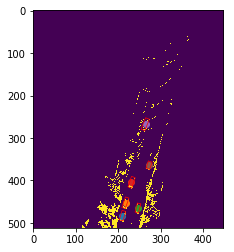

In [356]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 9:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][5] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    
    x1 = output[i][0]
    y1 = output[i][1]
    plt.scatter(y1, x1)
#     print(label[i][6]*57.2958, y, x, w, h)
    print(y, x, w, h)
    rect = patches.Rectangle((y, x),w, h, angle= label[i][6]*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')
    print(rect.get_width())
    ax.add_patch(rect)
#     break

plt.show()


In [79]:
all_data[4]

array([[31.29233393, -7.22326595, -1.37459077],
       [31.89534027, -5.70907116, -1.35228924],
       [35.68564376, -7.21885321, -1.3286316 ],
       [35.08263741, -8.733048  , -1.35093312],
       [31.27456993, -7.24122705,  0.32522164],
       [31.87757628, -5.72703226,  0.34752317],
       [35.66787976, -7.23681432,  0.37118081],
       [35.06487341, -8.75100911,  0.34887929]])

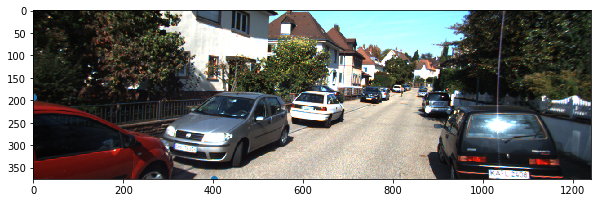

In [187]:
fig = plt.figure(figsize=(10, 8))
img = mpimg.imread(base_path + 'data_object_image_3/training/image_3/' + file_name + '.png')
# plt.scatter([741.18, 792.25], [168.83, 208.43])
# plt.scatter([597.59, 720.90], [ 176.18,  261.14])
plt.scatter([0, 402.31], [192.37, 374.00])
# plt.scatter([334.85, 624.50], [ 178.94,  372.04])
plt.imshow(img)

In [184]:
img.shape

(375, 1242, 3)

In [23]:
output2

array([[267.5304   , 264.84766  ,  21.828556 ,  34.991306 ,   9.537204 ,
         28.926634 ,   1.95     ,   1.       ,   1.       ],
       [364.15973  , 271.77316  ,  24.941416 ,  28.530167 ,   9.189821 ,
         17.655788 ,  -1.2499999,   1.       ,   1.       ],
       [404.48148  , 230.38776  ,  22.987865 ,  31.445133 ,   9.247619 ,
         26.162016 ,  -1.2499999,   1.       ,   1.       ],
       [452.50906  , 217.87112  ,  24.273005 ,  28.969429 ,   8.684184 ,
         26.276089 ,   1.9      ,   1.       ,   1.       ],
       [464.9836   , 245.6971   ,  24.808676 ,  27.058428 ,   8.23191  ,
         22.171999 ,  -1.3100001,   1.       ,   1.       ],
       [483.01718  , 209.32031  ,  25.313847 ,  27.927126 ,   9.006215 ,
         23.200777 ,  -1.2899998,   1.       ,   1.       ]],
      dtype=float32)

In [427]:
test1 = get_target(output, anchors=np.array([8.04520593, 2.62727732, 9.24066019]), input_size=(512, 448), output_size=(128, 112))

test2 = convert_prediction_into_real_values(test1)

print(test2)

[[264.        264.          0.          8.045206    2.6272774   9.24066
    1.5707964   0.          0.       ]
 [364.        268.          0.          8.045206    2.6272774   9.24066
    1.5707964   0.          0.       ]
 [404.        228.          0.          8.045206    2.6272774   9.24066
    1.5707964   0.          0.       ]
 [452.        216.          0.          8.045206    2.6272774   9.24066
    1.5707964   0.          0.       ]
 [464.        244.          0.          8.045206    2.6272774   9.24066
    1.5707964   0.          0.       ]
 [480.        208.          0.          8.045206    2.6272774   9.24066
    1.5707964   0.          0.       ]]


In [155]:
!cat /Users/apple/Desktop/Master/Data/data_object_calib/training/calib/000008.txt

P0: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 0.000000000000e+00 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.875744000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
P3: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.395242000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.199936000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.729905000000e-03
R0_rect: 9.999239000000e-01 9.837760000000e-03 -7.445048000000e-03 -9.

In [399]:
def __read_label(label_path, calib_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), size=(512, 448, 32)):
    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    lines = []
    with open(label_path) as label_file:
        lines = label_file.readlines()
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    lines = list(filter(lambda x: x[0] in ['Car', 'Van', 'Truck'], lines))
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = get_parameter(0)
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    

    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))



    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(classes))]
   
    x_range=(0, 70)
    y_range=(-40, 40)
    z_range=(-2.5, 1)
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    import math
    for i in range(len(points)):
        b = points[i]
        x0 = b[0][0]
        y0 = b[0][1]
        x1 = b[1][0]
        y1 = b[1][1]
        x2 = b[2][0]
        y2 = b[2][1]
        u0 = -(x0) * x_fac + size[0]
        v0 = -(y0 + 40) * y_fac + size[1]
        u1 = -(x1) * x_fac + size[0]
        v1 = -(y1 + 40) * y_fac + size[1]
        u2 = -(x2) * x_fac + size[0]
        v2 = -(y2 + 40) * y_fac + size[1]
        # print(dimension_length[i])
        dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
        # print(dimension_length[i])
        dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
        # print(dimension_height[i])
        dimension_height[i] = math.sqrt((-(b[0][2]+2.5)*z_fac+(-b[4][2]-2.5)*z_fac)**2)
        # print(dimension_height[i])

      


    # k = 3
    # output = [[-(points[i][k][0]) * x_fac + size[0], -(points[i][k][1] + 40) * y_fac + size[1], -(points[i][k][2] + 2.5) * z_fac + size[2], 
    #             dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
    #             for i in range(len(classes))]

    output = [[-(locations[i][0]) * x_fac + size[0], -(locations[i][1] + 40) * y_fac + size[1], -(locations[i][2] + 2.5) * z_fac + size[2], 
                dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
                for i in range(len(classes))]

    # for i in range(len(output)):
    #     w = output[i][5] 
    #     h = output[i][4] 
    #     x = output[i][0]
    #     y = output[i][1]

    #     rect = patches.Rectangle((y, x),w, h, angle= output[i][6]*57.2958)

    #     if output[i][6] >0:
    #         origin = np.array(rect.get_bbox().get_points()[0])
    #         point =  np.array(rect.get_bbox().get_points()[1])
    #         p = rotate(origin, point, output[i][6])
    #         output[i][0] = p[1]
    #         output[i][1] = p[0]
    #         output[i][6] = output[i][6] - 3.14

    
    output = np.array(list(filter(lambda point: point[0] >= x_range[0]  or point[0] <= x_range[1]
                                    and point[1] >= y_range[0] or point[1] <= y_range[1]
                                    and point[2] >= z_range[0] or point[2] <= z_range[1] , output)))

    
    
    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']


# Test the Model

In [15]:
model = Model()

W1205 22:32:22.791761 4600546752 deprecation.py:323] From .././utils/nms.py:14: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1205 22:32:28.888895 4600546752 deprecation.py:323] From .././utils/anchors.py:21: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W1205 22:32:28.901967 4600546752 deprecation_wrapper.py:119] From .././utils/anchors.py:27: The name tf.log is deprecated. Please use tf.math.log instead.

W1205 22:32:29.055183 4600546752 deprecation_wrapper.py:119] From .././model.py:120: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W1205 22:32:29.057110 4600546752 deprecation_wrapper.py:119] From .././model.py:122: The name tf.train.

In [ ]:
%%time
trainer = Trainer(model=model, data_base_path='/Users/apple/Desktop/Master/Data')

trainer.train_bev(batch_size=1, 
                epochs=1, debug=True)

Start epoch 0
